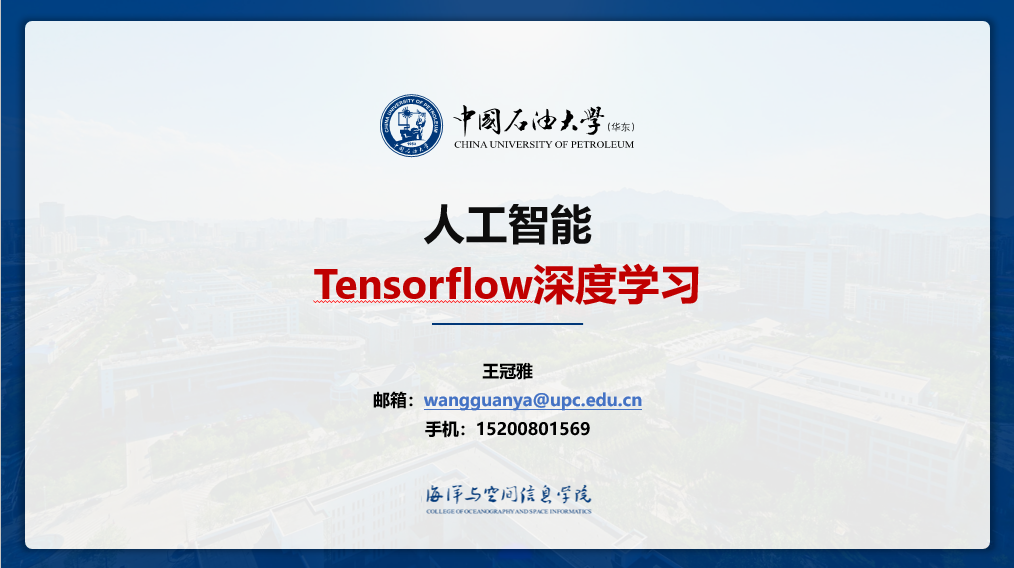
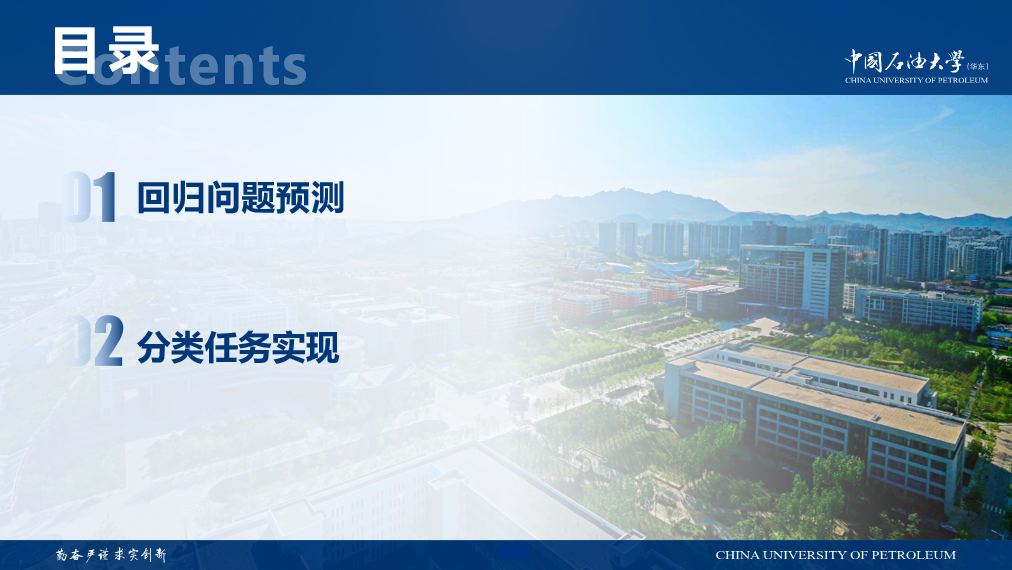
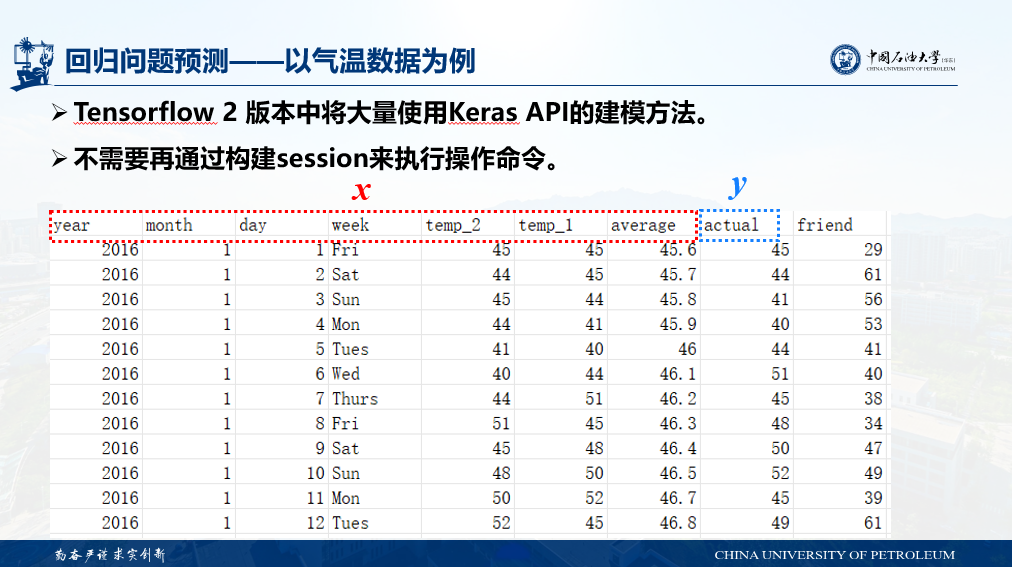
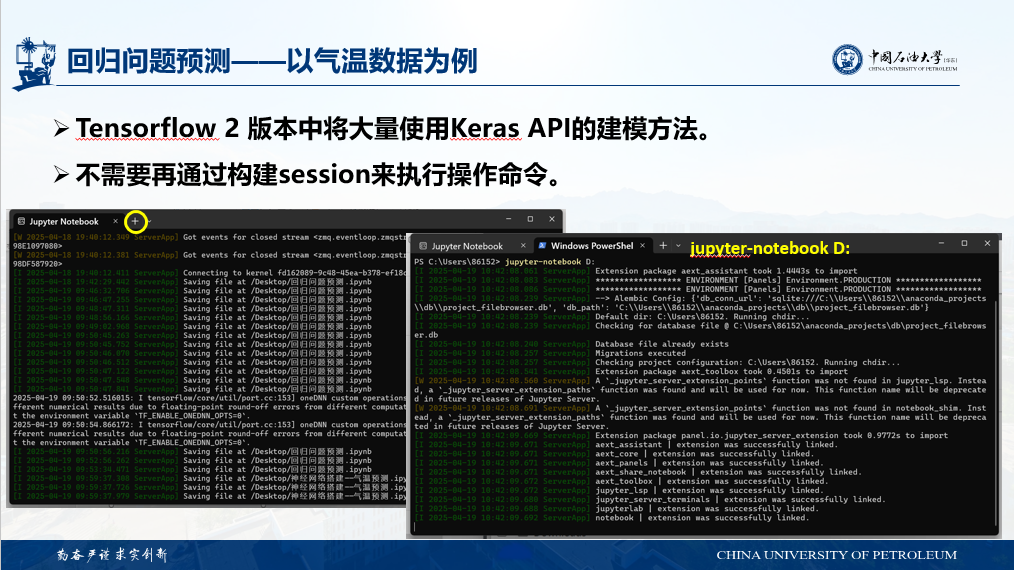

# 1. 回归问题预测——气温预测
**Tensorflow 2版本中将大量使用Keras的建模方法**
**Tensorflow 2版本不再需要使用session激活计算流程**

In [16]:
# 数据分析三剑客
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# tensorflow keras模块简化代码量
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras
import warnings
warnings.filterwarnings("ignore")

In [18]:
# 导入数据
features = pd.read_csv('temps.csv')
# 观察数据
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


数据表中
· year,month,day,week分别表示具体的时间
· temp_2:前天的最高温度值
· temp_1：昨天的最高温度值
· average：在历史中，每年这一天的平均最高温度值
· actual：标签值，当天的真实最高温度值
· friend: 别人猜测可能的温度值，无需理会。

In [21]:
print('数据维度：',features.shape)

数据维度： (348, 9)


In [23]:
# 为了展示方便，将时间数据处理成标准格式
import datetime

# 分别得到年,月,日
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

In [25]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

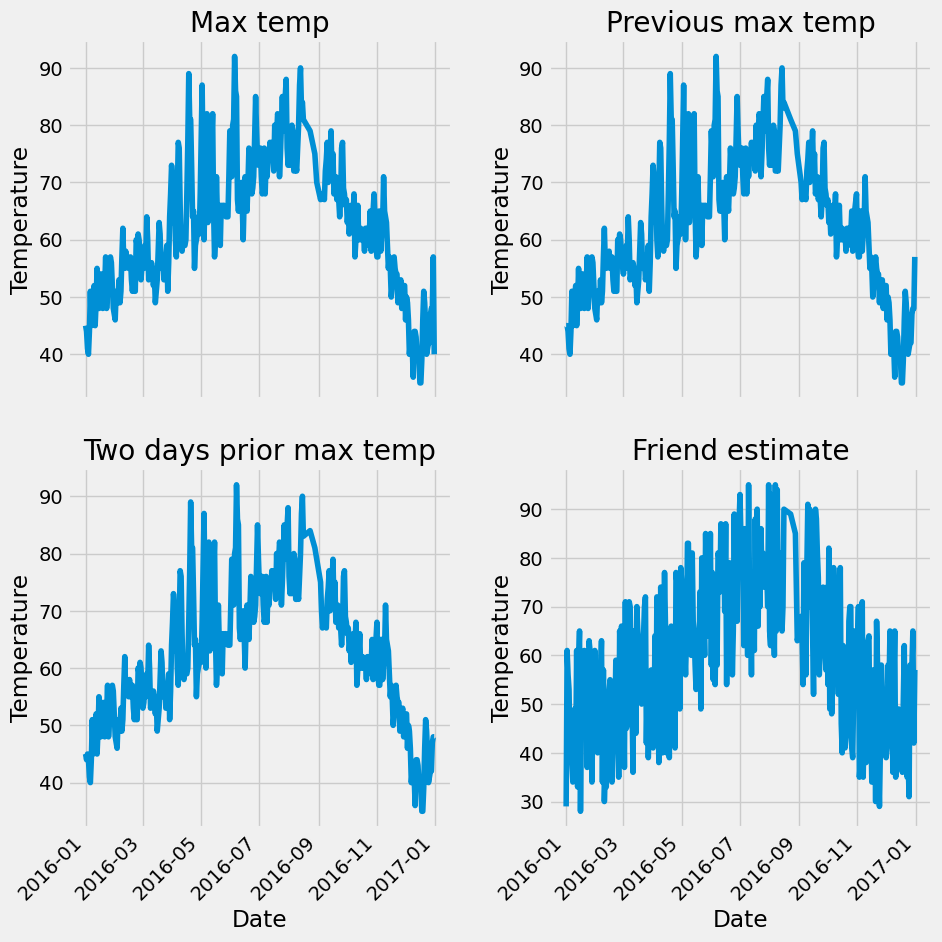

In [27]:
# 准备画图
# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous max temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two days prior max temp')

# 他人推测
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend estimate')

plt.tight_layout(pad=2)

**原始数据中的“星期x”的描述是字符串，无法直接使用，需要转换格式。**

In [30]:
# 独热编码
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False


## 建模操作
**先将x和y进行区分**

In [33]:
# 标签
labels = np.array(features['actual'])

# 在特征中去掉标签
features = features.drop('actual', axis = 1)

# 名字单独保存以备后患
feature_list = list(features.columns)

# 转换成合适的格式
features = np.array(features)

In [35]:
features.shape

(348, 14)

## 数据预处理：
### 图像数据: 可以将[0,255]的数据归一化到[0,1]
### 数值数据: 标准化处理（中心化+归一化）
### 文字数据: embedding处理

In [61]:
# 数值数据预处理:
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [63]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

## 基于Keras构建网络模型----tensorflow 2版本中的核心！！！
**一些常用参数：**
· activation: 激活函数的选择，一般常用Relu
· kernel_initializer, bias_initializer: 权重与偏置参数的初始化方法，不收敛的时候换种初始化方法可能就OK了
· kernel_regularizer, bias_regularizer: 决定是否要加入正则化
· inputs: 输入，可以自己指定，也可以让网络自动选
· units: 神经元个数

## 训练第一步：
确定两个问题 : 隐藏层层数及每层神经元个数（16，32）,最终输出数据的个数（1）
tensorflow 1 版本中除了要确定上述参数，还需要给定层与层之间的权重和偏置

In [67]:
# 按顺序构造网络模型,可以从tensorflow官网浏览所需模型
model = tf.keras.Sequential()
# 此处，我们选择使用全连接层
model.add(layers.Dense(16))
model.add(layers.Dense(32))
model.add(layers.Dense(1))

## 训练第二步
确定两个问题 ：优化器，损失函数
注意：不同损失函数对最终结果的影响很大，请在API中谨慎选择。

In [70]:
# compile相当于对网络进行配置,指定好优化器和损失函数等
# SGD：梯度下降
# MSE：损失函数——均方根误差
model.compile(optimizer=tf.keras.optimizers.SGD(0.001), loss='mean_squared_error')

In [72]:
model.fit(input_features,labels,validation_split=0.25, epochs=10, batch_size=64)
# 训练参数
# input_features: 训练的x
# labels: y
# validation_split: 执行过程中除了训练,还要进行验证,验证集数据所占比例是25%
# epochs: 遍历10遍
# batch_size: 每次迭代计算梯度,参数更新时所用样本数：64（建议选择大一些，可以是64,128等）

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4288.6567 - val_loss: 2768.1965
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3147.0386 - val_loss: 4542.1704
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 344.5616 - val_loss: 2114.4412
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 106.2512 - val_loss: 1600.9515
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 129.9521 - val_loss: 1265.3444
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 69.1463 - val_loss: 808.5955
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 106.3543 - val_loss: 636.0196
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 82.6019 - val_loss: 641.6830
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 42.9910 - val_loss: 506.9951
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 36.5282 - val_loss: 367.4712


上述训练过程经过10次迭代，可以发现：
1）随着迭代次数的增加，训练集和验证集的损失都逐渐减小；
2）最后一次训练结束时，训练集和验证集的损失差变大，尤其是训练集损失小，验证集损失大，这意味着出现了过拟合。

模型没有完全收敛，是否可以通过调节一些参数改善呢？

In [75]:
# 展示从上至下的逻辑结构:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 16)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 819 (3.20 KB)

 Trainable params: 817 (3.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [77]:
# Param的参数含义及计算过程：
# 1）明确输入：
input_features.shape

(348, 14)

In [79]:
# 14： 意味着每个样本有 14个特征
# 第一层 ：16个神经元 * 14个特征   w1:[14,16]   b1:[16,1]  14*16+16=240
# 第二层 : 32个神经元 * 16个特征   w2:[16,32]   b2:[32,1]  16*32+32=544
# 第三层 : 1个神经元 *  32个特征   w2:[32,1]    b2:[1，1]  32*1+1=33

## 更改初始化方法后

In [82]:
# 不选择默认的初始化，而是选择随机的高斯分布
model = tf.keras.Sequential()
model.add(layers.Dense(16,kernel_initializer='random_normal'))
model.add(layers.Dense(32,kernel_initializer='random_normal'))
model.add(layers.Dense(1,kernel_initializer='random_normal'))

In [84]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001), loss='mean_squared_error')
model.fit(input_features,labels,validation_split=0.25, epochs=100, batch_size=64)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4434.3838 - val_loss: 2865.6594
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4305.7222 - val_loss: 2776.4705
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4204.9839 - val_loss: 2642.0212
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3947.7502 - val_loss: 2363.9307
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2574.3708 - val_loss: 1702.7709
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 101.2166 - val_loss: 1472.8711
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 68.5723 - val_loss: 861.0212
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 51.0104 - val_loss: 640.4126
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 44.1438 - val_loss: 579.0132
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 37.3706 - val_loss: 364.5630
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 117.6167 - val_loss: 395.8028
Epoch 12/100
5/5 ━━━━━━

## 加入正则化惩罚项

In [89]:
model = tf.keras.Sequential()
model.add(layers.Dense(16,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.03)))
model.add(layers.Dense(32,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.03)))
model.add(layers.Dense(1,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.03)))

model.compile(optimizer=tf.keras.optimizers.SGD(0.001),loss='mean_squared_error')
model.fit(input_features,labels,validation_split=0.25, epochs=100, batch_size=64)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 4447.5210 - val_loss: 2869.8782
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4223.9082 - val_loss: 2787.1763
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4242.6792 - val_loss: 2669.1008
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4011.6140 - val_loss: 2462.0874
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3131.4863 - val_loss: 2595.6409
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 201.4756 - val_loss: 1614.8270
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 75.5879 - val_loss: 1522.7572
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 65.1008 - val_loss: 972.5389
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 48.4008 - val_loss: 723.6249
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 42.7596 - val_loss: 618.3732
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 31.6580 - val_loss: 500.5070
Epoch 12/100
5/5 ━━━━━━

 两种权重参数分析：1）波动较大；2）波动较小，那种权重参数更好呢？
 
 正常情况下，波动较小的权重参数更好，这样不会过拟合，且能获得更适合于测试集的稳定的训练结果。

## 预测模型结果

In [94]:
predict = model.predict(input_features)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [96]:
predict.shape

(348, 1)

## 测试结果并进行展示

In [105]:
# 转换日期格式
dates = [str(int(year)) +'-'+ str(int(month)) +'-'+ str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

# 创建一个表格来保存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date':dates,'actual':labels})

# 同理再创建一个来保存日期和其对应的模型预测值
months = features[:,feature_list.index('month')]
days = features[:,feature_list.index('day')]
years = features[:,feature_list.index('year')]

test_dates = [str(int(year)) +'-'+ str(int(month)) +'-'+ str(int(day)) for year, month, day in zip(years,months,days)]

test_dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data={'date':test_dates, 'prediction':predict.reshape(-1)})

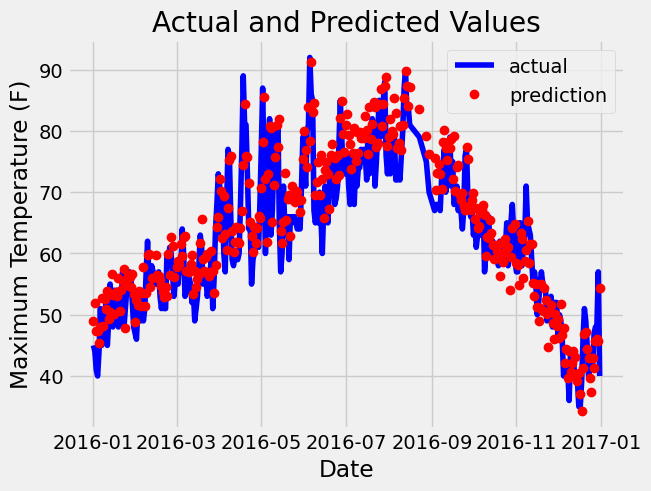

In [119]:
# 真实值
plt.plot(true_data['date'], true_data['actual'],'b-',label = 'actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'],'ro',label='prediction')
plt.legend()

# 图名
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

# 2. 分类任务——手写体识别

In [140]:
# 自动下载数据集
from pathlib import Path
import requests

DATA_PATH = Path("mnist")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

# URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/tree/master"
FILENAME = "mnist.pkl.gz"

# if not (PATH / FILENAME).exists():
#     content = requests.get(URL + FILENAME).content
#     (PATH / FILENAME).open("wb").write(content)

In [142]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(),"rb") as f:
    ((x_train, y_train),(x_valid, y_valid),_) = pickle.load(f, encoding="latin-1")

(50000, 784)


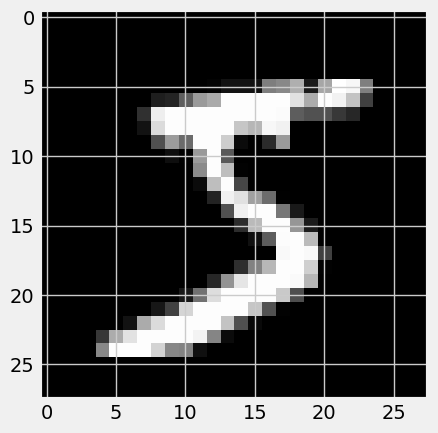

In [144]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28,28)),cmap="gray")
print(x_train.shape)

In [ ]:
# 请注意 784是mnist数据集每个样本的像素点个数

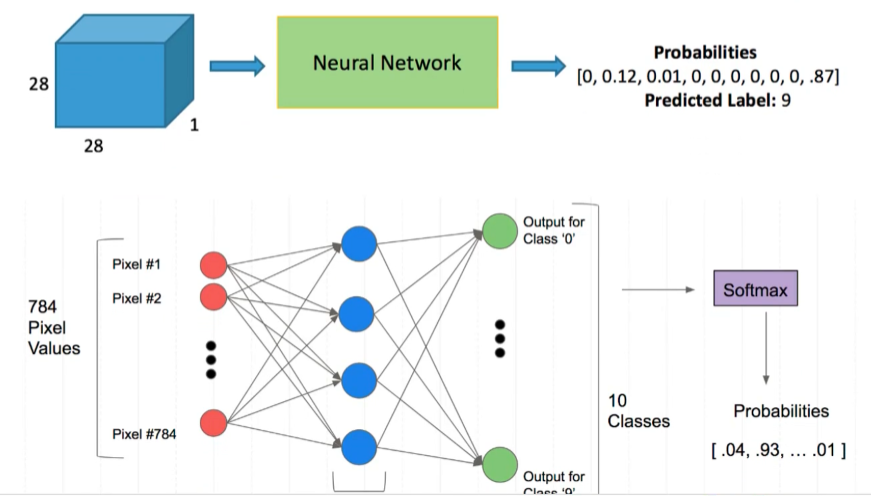

In [149]:
import tensorflow as tf
from tensorflow.keras import layers

In [151]:
model = tf.keras.Sequential()
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

**选择损失和评估函数时需要选择合适的Api参考：**
https://tensorflow.google.cn/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy?version=stable

**课后问题：为什么要选择keras.losses.SparseCategoricalCrossentropy作为损失函数？**

In [166]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.005),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
# 尝试修改学习率，提升分类结果！

In [168]:
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_valid, y_valid))

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9723 - val_loss: 0.1316 - val_sparse_categorical_accuracy: 0.9631
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0723 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.1336 - val_sparse_categorical_accuracy: 0.9641
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.1485 - val_sparse_categorical_accuracy: 0.9643
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0651 - sparse_categorical_accuracy: 0.9796 - val_loss: 0.1427 - val_sparse_categorical_accuracy: 0.9630
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0559 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.1562 - val_sparse_categorical_accuracy: 0.9629


# 3. tf.data模块常用函数

In [178]:
import numpy as np
input_data = np.arange(16)
input_data

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [182]:
# 直接构建张量数据集，生成能够遍历的数据集：numpy格式->tensor格式
dataset = tf.data.Dataset.from_tensor_slices(input_data)
for data in dataset:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(15, shape=(), dtype=int32)


**（1）repeat操作: 表示重复**

In [185]:
dataset = tf.data.Dataset.from_tensor_slices(input_data)
dataset = dataset.repeat(2)
for data in dataset:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(15, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(11, shape=(

**（2）batch操作: 表示挑选**

In [192]:
dataset = tf.data.Dataset.from_tensor_slices(input_data)
dataset = dataset.repeat(2).batch(4)
for data in dataset:
    print(data)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int32)
tf.Tensor([ 8  9 10 11], shape=(4,), dtype=int32)
tf.Tensor([12 13 14 15], shape=(4,), dtype=int32)
tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int32)
tf.Tensor([ 8  9 10 11], shape=(4,), dtype=int32)
tf.Tensor([12 13 14 15], shape=(4,), dtype=int32)


**(3) shuffle操作: 表示打乱顺序**

buffer_size参数不可省略，表示缓存区大小

In [204]:
dataset = tf.data.Dataset.from_tensor_slices(input_data).shuffle(buffer_size=10).batch(4)
for data in dataset:
    print(data)

tf.Tensor([4 9 3 5], shape=(4,), dtype=int32)
tf.Tensor([ 0  1 14 11], shape=(4,), dtype=int32)
tf.Tensor([10  6  8  7], shape=(4,), dtype=int32)
tf.Tensor([ 2 15 12 13], shape=(4,), dtype=int32)


**重新训练**

In [218]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.batch(32)
train = train.repeat()

valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid = valid.batch(32)
valid = valid.repeat()

model.fit(train, epochs=5, steps_per_epoch=100, validation_data=valid, validation_steps=100)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0719 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.2243 - val_sparse_categorical_accuracy: 0.9447
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1136 - sparse_categorical_accuracy: 0.9636 - val_loss: 0.2109 - val_sparse_categorical_accuracy: 0.9456
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.9558 - val_loss: 0.2358 - val_sparse_categorical_accuracy: 0.9394
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1440 - sparse_categorical_accuracy: 0.9591 - val_loss: 0.2281 - val_sparse_categorical_accuracy: 0.9428
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1443 - sparse_categorical_accuracy: 0.9537 - val_loss: 0.1662 - val_sparse_categorical_accuracy: 0.9572
